# 实验6 TensorFlow

从本次实验开始，你将探索一个名为TensorFlow的DL框架，它使得构建NN更加容易，类似的框架还有 PaddlePaddle, Torch, Caffe, Keras 等。

目标：使用TensorFlow 2.3进行如下操作
* 使用 `tf.Variable` 来表示变量
* 了解变量和常量的差别
* 使用TensorFlow来加速DL编程开发
* 在一个TensorFlow数据集上训练NN

可以使用 `pip install tensorflow==2.3` 来下载安装指定版本的TensorFlow

<a name='1'></a>
## 1 - 包

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

<a name='1-1'></a>
### 1.1 - 检查 TensorFlow 版本
本次实验中使用的tensorflow版本为 v2.3，下面的代码将打印输出其版本号

In [2]:
tf.__version__

'2.3.0'

<a name='2'></a>
## 2 - 使用GradientTape进行基本的优化

第二代TensorFlow的使用非常简洁. 仅需实现前向传播（TensorFlow将依据GradientTape中的记录信息自动计算梯度，并根据计算图进行反向传播），指定代价函数和优化器!

类似Numpy中的arrays对象，在TensorFlow中使用`tf.Tensor`来表示多维数组

下面，你将使用 `tf.Variable` 来存储你的变量，并在初始化时定义其形状和类型.
通过 `tf.Variable` 的构造函数中的 `dtype` 参数可以指定变量的类型.

### 2.0 - 数据集
下面的代码将从HDF5文件读取实验要使用的 TensorFlow 数据集，这是一个手势数据集, 包含分辨率为64x64x3的图片

In [3]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [4]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [5]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

你可以通过for循环来访问tensorflow数据集中的数据, 或者使用`iter`来创建一个Python的迭代器，并通过`next`来访问下一个元素.
你也可以通过`element_spec`属性来查看各个元素的`shape` 和 `dtype`。

In [6]:
print(y_train.element_spec)

TensorSpec(shape=(), dtype=tf.int64, name=None)


In [7]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [8]:
for element in x_train:
    print(element)
    break

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


如果要对TensorFlow数据集进行转换，需要使用 `map` 方法（如下所示）

In [9]:
"""
Function：
    Transform an image into a tensor of shape (64 * 64 * 3, 1)
    and normalize its components.
Arguments：
    image - Tensor.
Returns:
    result -- Transformed tensor
"""
def normalize(image):
    image = tf.cast(image, tf.float32) / 256.0
    image = tf.reshape(image, [-1,1])
    return image

In [10]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [11]:
new_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [12]:
print(next(iter(new_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)


<a name='2-1'></a>
### 2.1 - 线性函数

让我们计算: $Y = WX + b$, 其中 $W$ 和 $X$ 是随机矩阵，b 是一个随机向量

<a name='ex-1'></a>
#### 练习 1 - linear_function

计算 $WX + b$，其中 $W, X$, 和 $b$ 的元素值是服从正态分布的随机数. W 的形状为 (4, 3), X 为 (3,1)，b 为 (4,1).

*提示*:
- 下面的代码可以定义一个形状为(3,1)的常量X:
```python
X = tf.constant(np.random.randn(3,1))
```
`tf.constant` 和 `tf.Variable` 的区别在于：你可以改变一个`tf.Variable`的值，`tf.constant`则不行.
- tf.matmul(..., ...) 可以用来进行矩阵相乘
- tf.add(..., ...) 可以用来做加法
- np.random.randn(...) 可以用来随机初始化

In [13]:
"""
Function：
    Implements a linear function:
        Initializes X to be a random tensor of shape (3,1)
        Initializes W to be a random tensor of shape (4,3)
        Initializes b to be a random tensor of shape (4,1)
Returns:
    result -- Y = WX + b
"""
def linear_function():
    np.random.seed(1)
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    (Do not re-arrange the order).
    """
    # (approx. 4 lines)
    # X = ...
    # W = ...
    # b = ...
    # Y = ...
    # YOUR CODE STARTS HERE
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.Variable(np.random.randn(4,3), name = "X")
    b = tf.Variable(np.random.randn(4,1), name = "X")
    Y = W@X + b 
    # YOUR CODE ENDS HERE
    return Y

In [14]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")


tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


<a name='2-2'></a>
### 2.2 - 计算Sigmoid
TensorFlow 提供了NN中各种各样会用到的函数，例如`tf.sigmoid` 和 `tf.softmax`.
接下来你将实现计算z的sigmoid值，首先需要使用`tf.cast`将你的张量转换为`float32` 类型 , 然后调用 `tf.keras.activations.sigmoid`完成计算.

<a name='ex-2'></a>
#### 练习 2 - sigmoid

通过2步实现sigmoid函数:
1. 数据转换 `tf.cast("...", tf.float32)`
2. 函数调用 `tf.keras.activations.sigmoid("...")`

In [16]:
"""
Function：
    Computes the sigmoid of z
Arguments:
    z -- input value, scalar or vector
Returns:
    a -- (tf.float32) the sigmoid of z
"""
def sigmoid(z):
    # tf.keras.activations.sigmoid requires float16, float32, float64, complex64, or complex128.
    # (approx. 2 lines)
    # z = ...
    # a = ...
    # YOUR CODE STARTS HERE
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)
    # YOUR CODE ENDS HERE
    return a


In [17]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    assert sigmoid(12) == 0.9999939, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999939, shape=(), dtype=float32)
All test passed


<a name='2-3'></a>
### 2.3 - 使用 One Hot 编码

在之前的分类例子中，多个样本的标签$Y$通常被表示为一个取值$0$ 到 $C-1$的向量（$C$为类别数）。下图展示了将一个类别数为4的$Y$转换为名为"one hot"编码数据的结果。

<img src="images/onehot.png" width=1000>

要在numpy中实现该编码需要较多的代码，在TensorFlow则仅需一行代码:

- [tf.one_hot(labels, depth, axis=0)](https://www.tensorflow.org/api_docs/python/tf/one_hot)

当`axis=0`时，其输出数据的尺寸为 depth * len(labels)

<a name='ex-3'></a>
#### 练习 3 - one_hot_matrix

实现一个函数，其参数为一个标签和类别数$C$，返回列式的one hot编码矩阵（仅有1列）.
*提示*：
- 使用`tf.one_hot()`进行one hot编码
- 使用`tf.reshape(tensor, shape)` 改变矩阵形状!

In [20]:
"""
Function：
    Computes the one hot encoding for a single label
Arguments:
    label --  (int) Categorical labels
    depth --  (int) Number of different classes that label can take
Returns:
    one_hot -- (tf.Tensor) A single-column matrix with the one hot encoding.
"""
def one_hot_matrix(label, depth=6):
    # (approx. 1 line)
    # one_hot = ...
    # YOUR CODE STARTS HERE
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), [depth,1])
    # YOUR CODE ENDS HERE
    return one_hot

In [21]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print(result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert result.shape[1] == 1, f"Reshape to have only 1 column"
    assert np.allclose(result,  [[0.], [1.], [0.], [0.]] ), "Wrong output. Use tf.one_hot"
    result = target(3, depth)
    assert np.allclose(result, [[0.], [0.], [0.], [1.]] ), "Wrong output. Use tf.one_hot"

    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]], shape=(4, 1), dtype=float32)
All test passed


查看转换后的数据

In [22]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [23]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


<a name='2-4'></a>
### 2.4 - 参数初始化

你将初始化一个取值[0,1]的向量，所调用的函数为 `tf.keras.initializers.GlorotNormal`, 其生成的随机数服从均值为0、标准差`stddev = sqrt(2 / (fan_in + fan_out))`的截断的正态分布，其中 `fan_in` 和 `fan_out` 分别表示输入、输出单元的个数

全0或全1初始化可使用 `tf.zeros()` or `tf.ones()`.

<a name='ex-4'></a>
#### 练习 4 - initialize_parameters

实现下面的函数，其输入参数为形状shape，返回值为取值[-1,1]之间的数组.步骤包括：
- `tf.keras.initializers.GlorotNormal(seed=1)`
- `tf.Variable(initializer(shape=())`

In [24]:
"""
Function：
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
        W1 : [25, 12288]
        b1 : [25, 1]
        W2 : [12, 25]
        b2 : [12, 1]
        W3 : [6, 12]
        b3 : [6, 1]
Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
"""
def initialize_parameters():
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    #(approx. 6 lines of code)
    # W1 = ...
    # b1 = ...
    # W2 = ...
    # b2 = ...
    # W3 = ...
    # b3 = ...
    # YOUR CODE STARTS HERE
    W1 = tf.Variable(initializer(shape=([25, 12288])))
    b1 = tf.Variable(initializer(shape=([25, 1])))
    W2 = tf.Variable(initializer(shape=([12, 25])))
    b2 = tf.Variable(initializer(shape=([12, 1])))
    W3 = tf.Variable(initializer(shape=([6, 12])))
    b3 = tf.Variable(initializer(shape=([6, 1])))
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [25]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


In [26]:
parameters = initialize_parameters()

<a name='3'></a>
## 3 - 使用TensorFlow构建你的第一个NN

需要做两部分工作：
- 实现前向传播
- 检索得到梯度并训练模型

<a name='3-1'></a>
### 3.1 - 实现前向传播

你将使用 `@tf.function`, 它将构建一个计算图，以便计算梯度用于反向传播.

<a name='ex-5'></a>
#### 练习 5 - forward_propagation

实现 `forward_propagation` 函数.

**注意**
仅使用TF的API接口，包括：
- tf.math.add
- tf.linalg.matmul
- tf.keras.activations.relu

In [27]:
"""
Function：
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
Returns:
    Z3 -- the output of the last LINEAR unit
"""
@tf.function
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    #(approx. 5 lines)                   # Numpy Equivalents:
    # Z1 = ...                           # Z1 = np.dot(W1, X) + b1
    # A1 = ...                           # A1 = relu(Z1)
    # Z2 = ...                           # Z2 = np.dot(W2, A1) + b2
    # A2 = ...                           # A2 = relu(Z2)
    # Z3 = ...                           # Z3 = np.dot(W3, A2) + b3
    # YOUR CODE STARTS HERE
    Z1 = tf.math.add(tf.linalg.matmul(W1,X), b1)                          
    A1 = tf.keras.activations.relu(Z1)                                     
    Z2 = tf.math.add(tf.linalg.matmul(W2,A1), b2)                                   
    A2 = tf.keras.activations.relu(Z2)                                       
    Z3 = tf.math.add(tf.linalg.matmul(W3,A2), b3)
    # YOUR CODE ENDS HERE
    return Z3

In [28]:
def forward_propagation_test(target, examples):
    for batch in examples:
        forward_pass = target(batch, parameters)
        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 1), "Last layer must use W3 and b3"
        assert np.any(forward_pass < 0), "Don't use a ReLu layer at end of your network"
        assert np.allclose(forward_pass, 
                           [[-0.13082162],
                           [ 0.21228778],
                           [ 0.7050022 ],
                           [-1.1224034 ],
                           [-0.20386729],
                           [ 0.9526217 ]]), "Output does not match"
        print(forward_pass)
        break
    

    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf.Tensor(
[[-0.13082099]
 [ 0.21228725]
 [ 0.7050022 ]
 [-1.1224037 ]
 [-0.2038675 ]
 [ 0.95262194]], shape=(6, 1), dtype=float32)
All test passed


<a name='3-2'></a>
### 3.2 计算代价

下面的代码展示了计算代价函数的一种方式

`tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = ..., y_pred = ..., from_logits=True))`

<a name='ex-6'></a>
#### 练习 6 -  compute_cost

实现下面的代价函数
- 需要特别注意的是[tf.keras.losses.binary_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy) 的输入"`y_pred`" 和 "`y_true`"，其形状应该是 (number of examples, num_classes).
- `tf.reduce_mean` 用于计算tensor沿着指定的数轴上的平均值.

In [29]:
"""
Function：
    Computes the cost
Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    labels -- "true" labels vector, same shape as Z3
Returns:
    cost - Tensor of the cost function
"""
@tf.function
def compute_cost(logits, labels):
    #(1 line of code)
    # cost = ...
    # YOUR CODE STARTS HERE
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = labels, y_pred = logits, from_logits=True))
    # YOUR CODE ENDS HERE
    return cost

In [30]:
def compute_cost_test(target):
    labels = np.array([[0., 1.], [0., 0.], [1., 0.]])
    logits = np.array([[0.6, 0.4], [0.4, 0.6], [0.4, 0.6]])
    result = compute_cost(logits, labels)
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.7752516 +  0.9752516 + 0.7752516) / 3.0) < 1e-7), "Test does not match. Did you get the mean of your cost functions?"

    print("\033[92mAll test passed")

compute_cost_test(compute_cost)

tf.Tensor(0.8419182681095858, shape=(), dtype=float64)
All test passed


<a name='3-3'></a>
### 3.3 - 训练模型

Let's talk optimizers. You'll specify the type of optimizer in one line, in this case `tf.keras.optimizers.Adam` (though you can use others such as SGD), and then call it within the training loop. 

Notice the `tape.gradient` function: this allows you to retrieve the operations recorded for automatic differentiation inside the `GradientTape` block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do. ;) 


Here you should take note of an important extra step that's been added to the batch training process: 

- `tf.Data.dataset = dataset.prefetch(8)` 

What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory. 

In [31]:
"""
Function:
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
"""
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    costs = []     # To keep track of the cost
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.SGD(learning_rate)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            # Select a minibatch
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)
                
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size

        # Print the cost every epoch
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print ("Parameters have been trained!")

    return parameters

Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
Cost after epoch 50: 0.570628
Cost after epoch 60: 0.560898
Cost after epoch 70: 0.550808
Cost after epoch 80: 0.540497
Cost after epoch 90: 0.488141
Cost after epoch 100: 0.478272
Cost after epoch 110: 0.472865
Cost after epoch 120: 0.468991
Cost after epoch 130: 0.466015
Cost after epoch 140: 0.463661
Cost after epoch 150: 0.461677
Cost after epoch 160: 0.459951
Cost after epoch 170: 0.458392
Cost after epoch 180: 0.456970
Cost after epoch 190: 0.455646


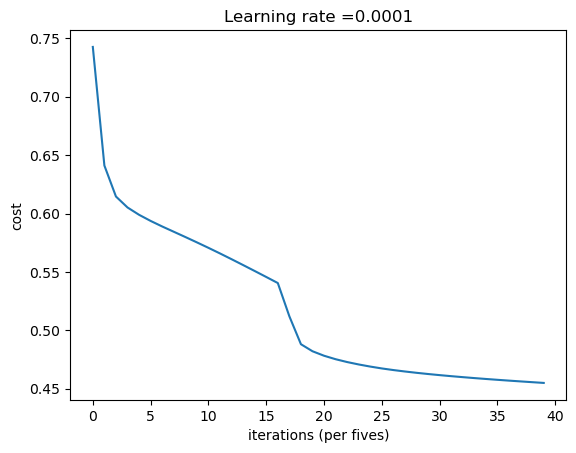

Parameters have been trained!


{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[ 0.00159524, -0.00737916,  0.00893293, ..., -0.01227792,
          0.01642205,  0.00506485],
        [ 0.02264025,  0.0067227 ,  0.00795862, ...,  0.00284724,
          0.01910819,  0.00122853],
        [-0.0017358 , -0.00872449, -0.01410439, ..., -0.00733832,
          0.02050859, -0.02683017],
        ...,
        [-0.00126929,  0.01729332,  0.02082342, ...,  0.01709594,
          0.00429358, -0.00733263],
        [ 0.00268265,  0.00410502,  0.00936712, ...,  0.01222286,
         -0.02717603,  0.01498357],
        [-0.00145541,  0.02459595,  0.00339064, ..., -0.02478788,
          0.02716016, -0.00306428]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(25, 1) dtype=float32, numpy=
 array([[ 0.03964259],
        [-0.15545043],
        [ 0.19885877],
        [-0.24874453],
        [-0.28676733],
        [-0.12604602],
        [-0.01213097],
        [ 0.14784054],
        [-0.00413176],
        

In [32]:
model(new_train, new_y_train, new_test, new_y_test, num_epochs=200)

**Expected output**

```
Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
...
```

**Congratulations**! You've made it to the end of this assignment, and to the end of this week's material. Amazing work building a neural network in TensorFlow 2.3! 

Here's a quick recap of all you just achieved:

- Used `tf.Variable` to modify your variables
- Applied TensorFlow decorators and observed how they sped up your code
- Trained a Neural Network on a TensorFlow dataset

You are now able to harness the power of TensorFlow's computational graph to create cool things, faster. Nice!